# Why So Harsh: Harsh Comment Detection using NLP
This project aims to build a model to detect and classify toxic comments into six distinct categories: "harsh," "extremely harsh," "vulgar," "threatening," "disrespect," and "targeted hate." We will leverage NLP techniques and machine learning models to achieve this goal.

### importing necessary packages

In [ ]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import string
import matplotlib_venn as venn
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
import re
import matplotlib.gridspec as gridspec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
color = sns.color_palette()


# Tweet tokenizer does not split at apostophes
from nltk.tokenize import TweetTokenizer

In [ ]:
train = pd.read_csv("train.csv", engine="python")

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
train.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,52e0f91a5d7b74552c55,New Main Picture \n\nHow about this for the ma...,0,0,0,0,0,0
1,e2c8e370a8e53ba26bae,Think of them like population charts. Just bec...,0,0,0,0,0,0
2,03c807f61149a13c8404,This page seems a little misleading. The reaso...,0,0,0,0,0,0
3,fc63a1ba3372899db19f,"""\n\nActually, accounts are never deleted. """,0,0,0,0,0,0
4,0c2bfd9cde8974d9915f,"""\n\nYeah yeah, OK. So did I. Still, what I ...",0,0,0,0,0,0


In [ ]:
train.shape

(127656, 8)

In [ ]:
test.head()

,id,text
0,25f48f649f60423c091b,", 19 May 2006 (UTC)\nThey debate, they don't v..."
1,5c7ac6d7fb400bbadfc7,"""\n\nI am completely nonplussed at this """"We'v..."
2,d00a363d57952496854f,"""\n\nUnblock request\n\nCategory:User block te..."
3,b082c69afa60b378503d,"Dave 1185 \n\nIf you have a moment, can you he..."
4,1a585118ed7e1f29b38b,WarningPlease stop adding nonsense to Wikipedi...


In [ ]:
test.shape

(31915, 2)

In [ ]:
train['text'].head(5)

0    New Main Picture \n\nHow about this for the ma...
1    Think of them like population charts. Just bec...
2    This page seems a little misleading. The reaso...
3       "\n\nActually, accounts are never deleted.   "
4    "\n\nYeah yeah, OK.  So did I.  Still, what I ...
Name: text, dtype: object


## Exploratory Data Analysis

In [ ]:
#checking how many comments are 'clean': without any tag

x=train.iloc[:,2:8].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:8].sum(axis=1)

train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()

print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  127656
Total clean comments =  114692
Total tags = 28117


In [ ]:
#missing values

print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
#print("Check for missing values in Test dataset")
#null_check=test.isnull().sum()
#print(null_check)
print("filling NA with \"unknown\"")
train["text"].fillna("unknown", inplace=True)
#test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
clean              0
dtype: int64
filling NA with "unknown"


EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


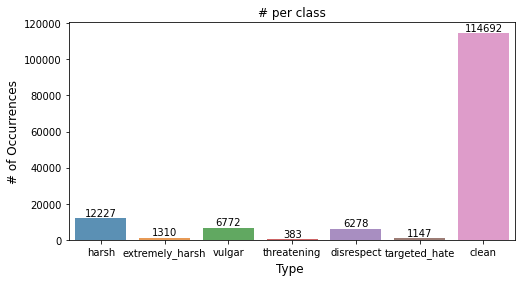

In [ ]:
#visualizing the distribution of tags

x=train.iloc[:,2:].sum()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
#it is not evenly spread out, most of the comments are tagged as harsh, threatning is very few.
#multiple tags are associated with each comment, thats wht the imbalance

In [ ]:
x=rowsums.value_counts()
x

0    114692
1      5063
3      3334
2      2799
4      1415
5       324
6        29
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


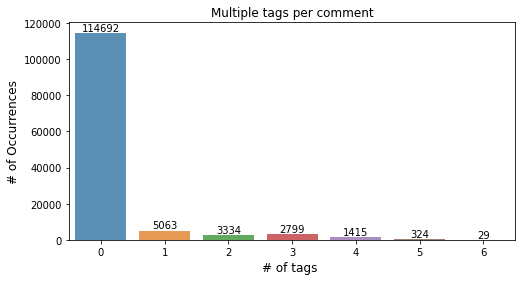

In [ ]:
#checking how many comments having multi tagging

x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
#almost 30 comments are there which are tagged for all categories

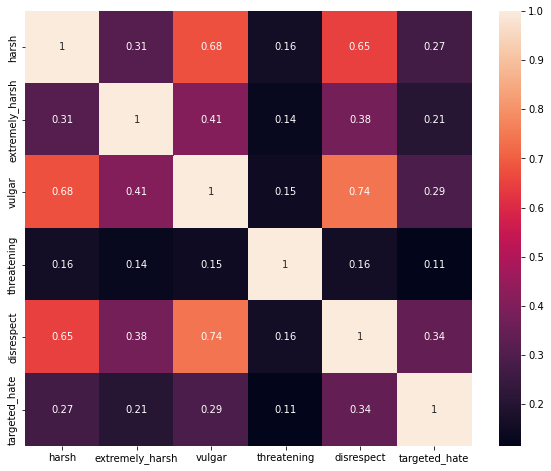

In [ ]:
#using corelation plot to see which tags go togther most often

temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [ ]:
#these are categorical variables so pearson correlation is not a good method. we can try other methods like :
#confusion matrix
#cramer's v stat (which also measures the association of strength, it is an extension of chi square test)

In [ ]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a
# look at harsh with other tags
main_col="harsh"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [ ]:
#it can be seen, most of the times 'extremely harsh comment' is also 'harsh'.
#only 75 comments are there which are targeted_hate as well as harsh

In [ ]:
print("vulgar:")
print(train[train.vulgar==1].iloc[4,1])


vulgar:
i hope they aren't breaking up for good because that would suck. there my favorite band ever!!!


In [ ]:

print("extremely harsh:")
print(train[train.extremely_harsh==1].iloc[4,1])


extremely harsh:
YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUC

In [ ]:
print("harsh:")
print(train[train.harsh==1].iloc[4,1])


harsh:
You had no right to call me that disgusting name.  I think you should be banned, you worthless waste of space.


In [ ]:
print("threatening:")
print(train[train.threatening==1].iloc[4,1])


threatening:
FUCK YOU 

YOU ARE THE BIGGEST PIG ON THE PLANET.

DIE IN HELL ASSHOLE!


In [ ]:
print("disrespect:")
print(train[train.disrespect==1].iloc[4,1])


disrespect:
Comment from Kansai Goma 

I still have more accounts on here which you will never find because I am too smart for you dickheads and you are a dumass.

fuck ya!


In [ ]:
print("targeted hate:")
print(train[train.targeted_hate==1].iloc[4,1])


targeted hate:
I'm scared. It resets daily. Fuck you and your Zionist buddies. I will continue to edit this page in GOOD FAITH until I get bored battling Jewbotts.


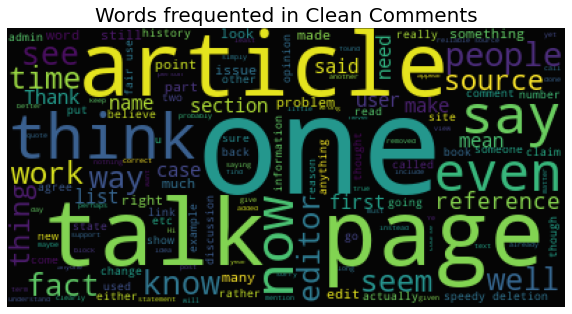

In [ ]:
#word cloud (frequent words)

stopword = set(STOPWORDS)


#wordcloud for clean comments

subset=train[train.clean==True]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))


plt.figure(figsize=(10,7))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

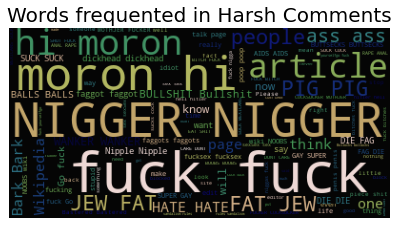

In [ ]:
#wordcloud for harsh comments in each category

subset=train[train.harsh==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Harsh Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

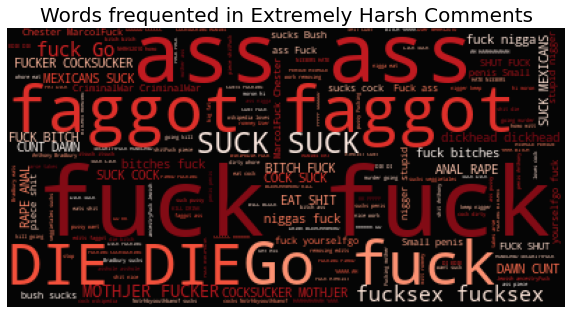

In [ ]:
#extremely_harsh comments

subset=train[train.extremely_harsh==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,7))
plt.axis("off")
plt.title("Words frequented in Extremely Harsh Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

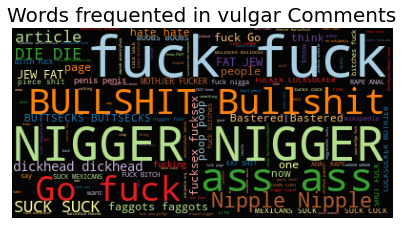

In [ ]:
#vulgar



subset=train[train.vulgar==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,11))
plt.subplot(224)
plt.axis("off")
plt.title("Words frequented in vulgar Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

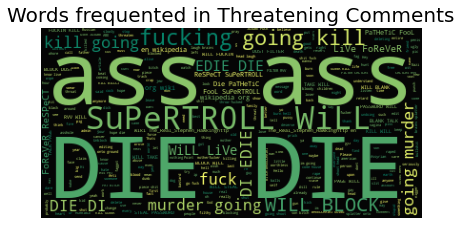

In [ ]:
#threatening



subset=train[train.threatening==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,11))
plt.subplot(223)
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

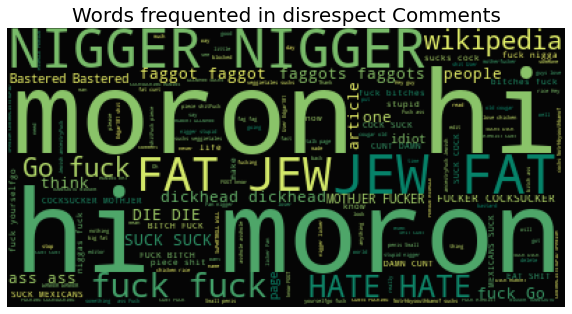

In [ ]:
#disrespect

subset=train[train.disrespect==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))

plt.figure(figsize=(10,7))

plt.axis("off")
plt.title("Words frequented in disrespect Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

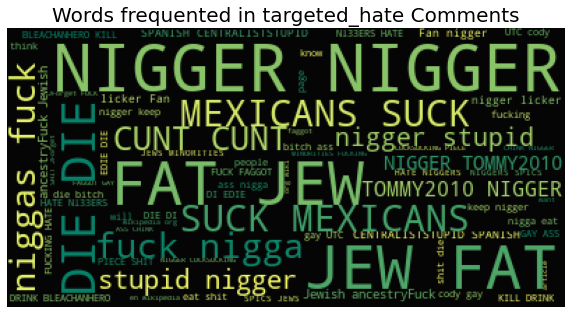

In [ ]:
#targeted_hate

subset=train[train.targeted_hate==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))

plt.figure(figsize=(10,7))

plt.axis("off")
plt.title("Words frequented in targeted_hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

## feature engineering

In [ ]:
#merging train and test data

merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
## Indirect features


#Sentense count in each comment:
#  '\n' can be used to count the number of sentences in each comment

df['count_sent']=df["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)


#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))

#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#derived features

#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']

#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
#serperate train and test features

train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]

#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


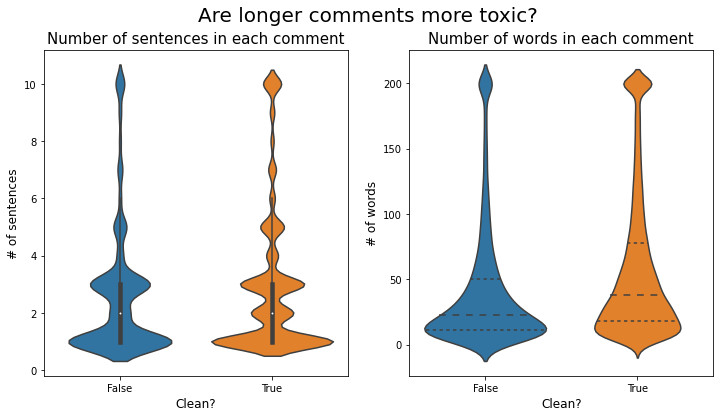

In [ ]:
#violin plot to check if longer comments are more harsh

train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10
plt.figure(figsize=(12,6))

## sentences
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)

# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [ ]:
#there is not any significant relation between longer sentence and it being toxic

In [ ]:
#chekcing if comments with unique words are more spam or not

train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200


#splitting the violin plot
#melting the data in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


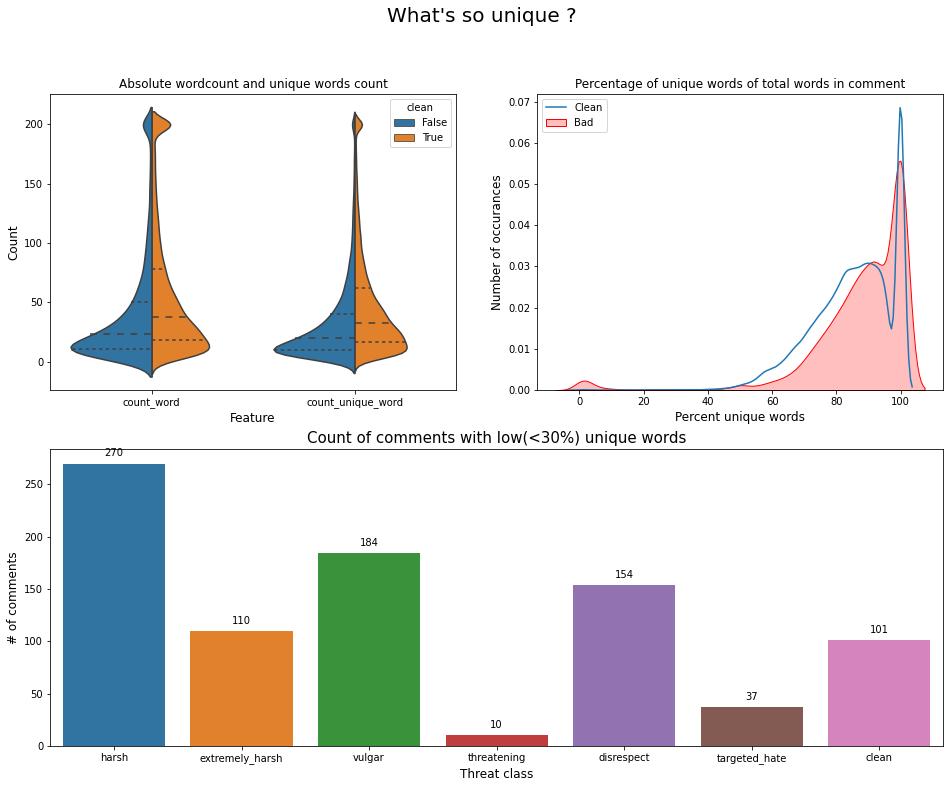

In [ ]:
#plotting (1st plot)

plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)


#2nd plot of kde
plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")

#sns
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)


x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

In [ ]:
#from the first chart, more unique words meaning more chance of being toxic comment

In [ ]:
#spam comment detection (where one toxic/harsh sentence is repeated multiple times)
#finding spam for both clean comments as well as harsh comments

print("Clean Spam example:")
print(spammers[spammers.clean==1].text.iloc[1])
print("Harsh Spam example:")
print(spammers[spammers.harsh==1].text.iloc[2])

Clean Spam example:
UNBLOCK SHANNON! ===     === UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 U

In [ ]:
#Leaky features

#checking for IP address
df['ip']=df["text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))

#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))


#username
df['username']=df["text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))


# count vectorizer for Leaky IPs
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Using count vectorizer for leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [ ]:
df[df.count_usernames!=0].text.iloc[0]

'"#369"">JARED]]\u2002(t)\u2002\n|}\n\nFuture signatures\n{| class=""wikitable"" border=""1""\n! Description\n! Signature\n|-\n| Olympics colors\n| [[User:JP06035|→'

In [ ]:
# check few user names
cv.get_feature_names()[120:130]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['king',
 'koshvorlon',
 'kuban',
 'kungming2',
 'lance6968',
 'likelakers2',
 'lopez',
 'lucasbfr',
 'lumos3',
 'luna']

In [ ]:
## leaky feature stability

leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

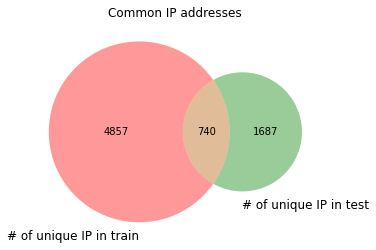

In [ ]:
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]

#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

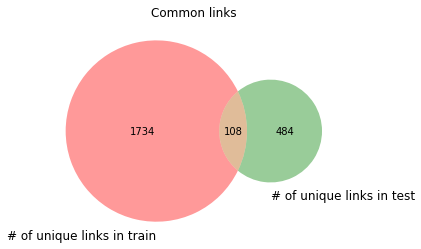

In [ ]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]

#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

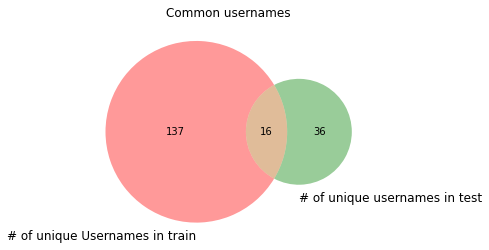

In [ ]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

In [ ]:
## corpus cleaning before creating count features

corpus=merge.text

In [ ]:
# Aphost lookup dict
#looking for full form of the short form of words

APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)

    #Split the sentences into words
    words=tokenizer.tokenize(comment)

    # (')aphostophe  replacement (ie)   you're --> you are
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)

    words=[APPO[word] if word in APPO else word for word in words]

    #lemmatize
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]

    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [ ]:
corpus.iloc[11125]

'"\n\nEDIT: Damn, I just lost everything I typed. Basically, 1: Not trying to promote Westside 2: Westside is not my comic. ""When he asked me to create a site about it (he\'s not great with these things) I of course immediately thought ""What better than Wikipedia?""""\n3: Wikipedia is too much of a hassle, so I\'ll make a MySpace or something. Westside will never be good enough, I guess..."'

In [ ]:
clean(corpus.iloc[11125])

'" edit : damn , lose everything type . basically , 1 : try promote westside 2 : westside comic . " " ask create site ( he is great things ) course immediately think " " better wikipedia ? " " " 3 : wikipedia much hassle , I will make myspace something . westside never good enough , guess ... "'

In [ ]:
clean_corpus=corpus.apply(lambda x :clean(x))

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
### direct features

TF-IDF Visualization

In [ ]:
#unigrams

#TF-IDF
tfv = TfidfVectorizer(min_df=100,  max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),  #unigram
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

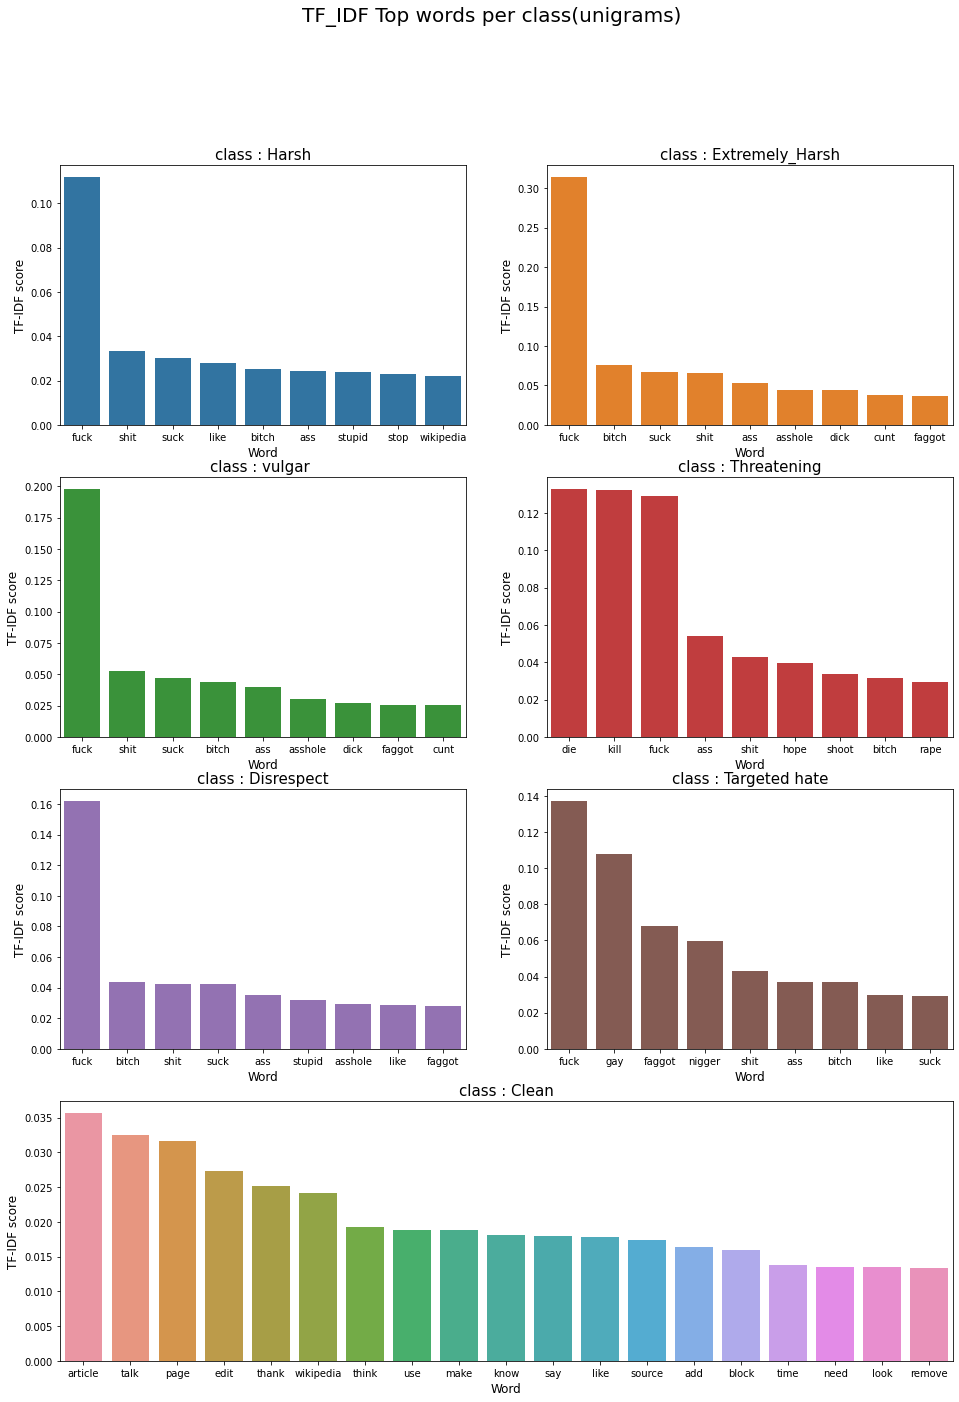

In [ ]:
#plotting TF-IDF top words in each category


plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Harsh",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Extremely_Harsh",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : vulgar ",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)



plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threatening",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Disrespect",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Targeted hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()



In [ ]:
### TF-IDF for bigrams

tfv = TfidfVectorizer(min_df=150,  max_features=30000,
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),   #bigram
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

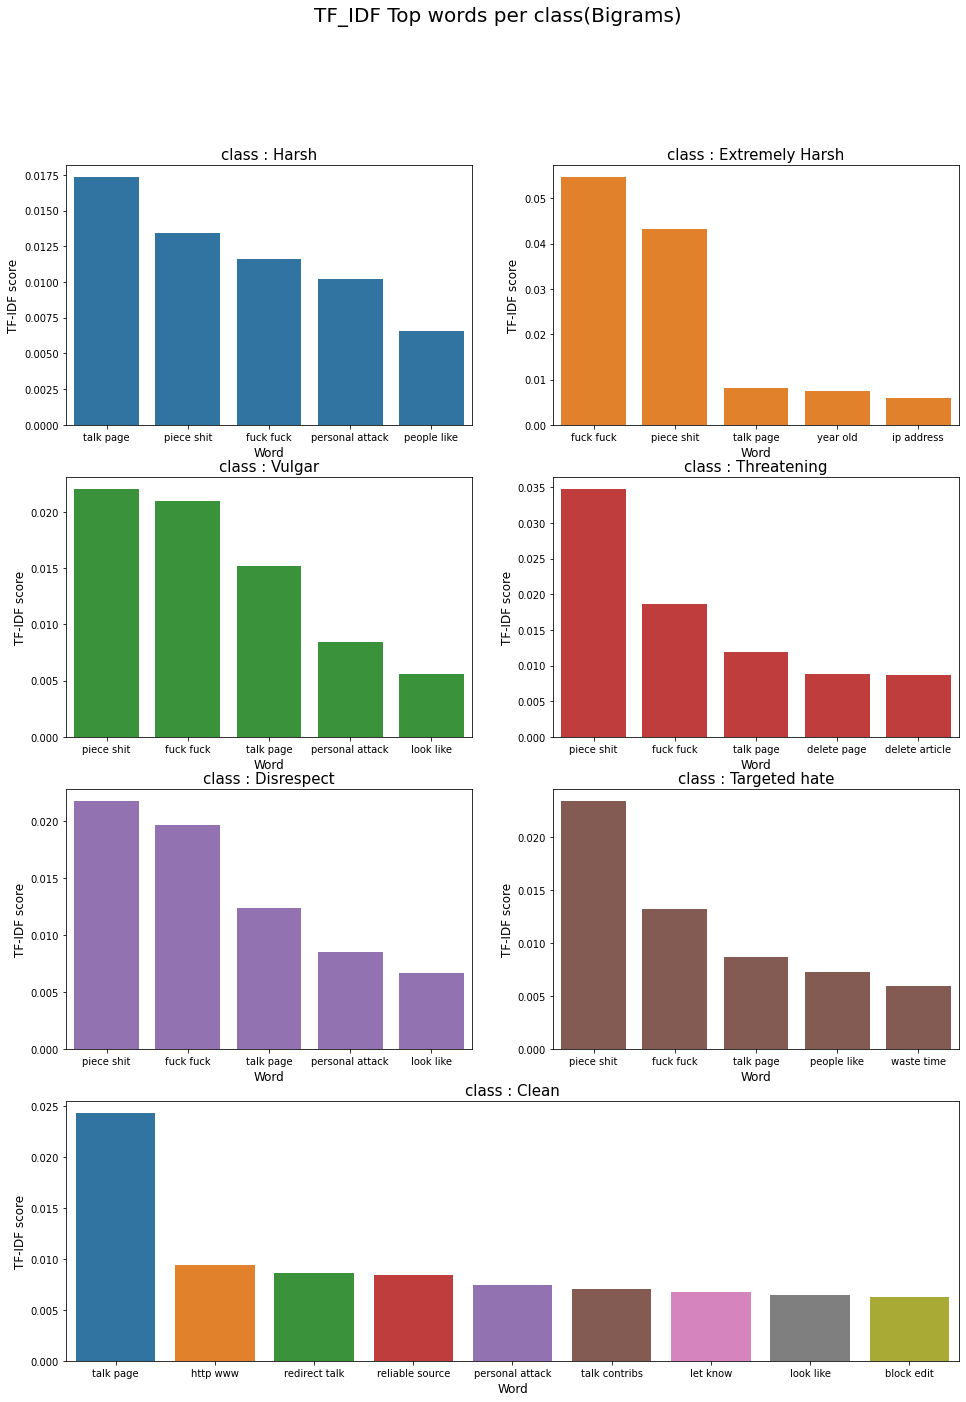

In [ ]:
##plotting for bigrams

plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Harsh",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Extremely Harsh",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Vulgar",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threatening",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Disrespect",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Targeted hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()



## Model Building

In [ ]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']

# target_x
target_x=train_feats[SELECTED_COLS]

class_names = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']



##  Logistic Regression Model

In [ ]:
#checking for null values in test data

k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

#test data containing some NaN values, that we have to deal with

,train,test
id,0,0.0
text,0,0.0
harsh,0,NaN
extremely_harsh,0,NaN
vulgar,0,NaN
threatening,0,NaN
disrespect,0,NaN
targeted_hate,0,NaN
clean,0,NaN


In [ ]:
test.fillna(' ',inplace=True)

TF-IDF

In [ ]:
#TF-IDF vectorization for word and characters

vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [ ]:
# Word ngram vector
tr_vect = vect_word.fit_transform(train['text'])
ts_vect = vect_word.transform(test['text'])

# Character n gram vector
tr_vect_char = vect_char.fit_transform(train['text'])
ts_vect_char = vect_char.transform(test['text'])

In [ ]:
from scipy import sparse
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.linear_model import LogisticRegression

In [ ]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

target_col = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']
y = train[target_col]
del tr_vect, ts_vect, tr_vect_char, ts_vect_char

# Prediction with: First Best Approach (Logistic Regression with TF-IDF)

In [ ]:
 prd = np.zeros((x_test.shape[0],y.shape[1]))
 cv_score =[]
 for i,col in enumerate(target_col):
     lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced')
     print('Building {} model for column:{''}'.format(i,col))
     lr.fit(X,y[col])
     #cv_score.append(lr.score)
     prd[:,i] = lr.predict_proba(x_test)[:,1]

Building 0 model for column:harsh


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 1 model for column:extremely_harsh


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 2 model for column:vulgar


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 3 model for column:threatening
Building 4 model for column:disrespect


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 5 model for column:targeted_hate


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
 col = 'disrespect'
 print("Column:",col)
 pred =  lr.predict(X)
 print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
 print(classification_report(y[col],pred))


Column: disrespect

Confusion matrix
 [[120622    756]
 [  4584   1694]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    121378
           1       0.69      0.27      0.39      6278

    accuracy                           0.96    127656
   macro avg       0.83      0.63      0.68    127656
weighted avg       0.95      0.96      0.95    127656



Column: disrespect


Text(0.5, 1.0, 'Reciever Operating Characteristic')

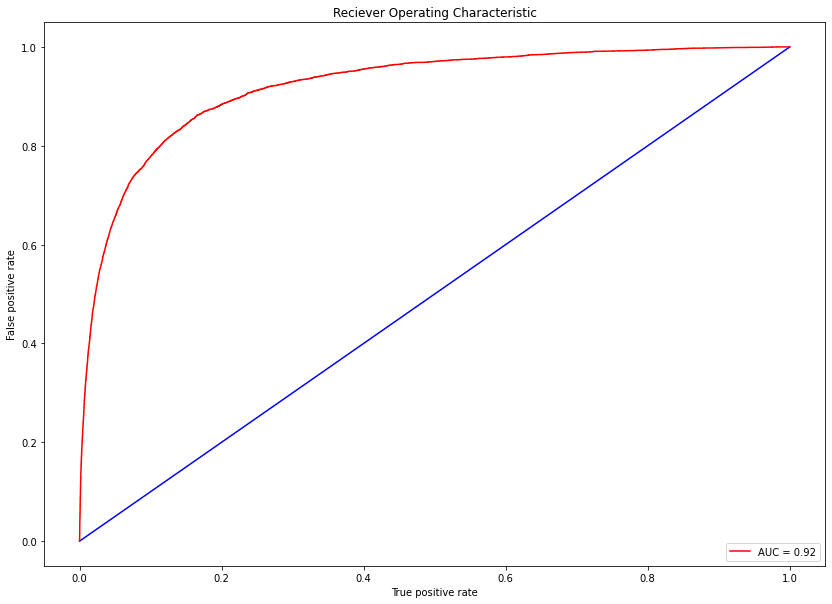

In [ ]:
# #ROC AUC curve

 col = 'disrespect'
 print("Column:",col)
 pred_pro = lr.predict_proba(X)[:,1]
 frp,trp,thres = roc_curve(y[col],pred_pro)
 auc_val =auc(frp,trp)
 plt.figure(figsize=(14,10))
 plt.plot([0,1],[0,1],color='b')
 plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
 plt.legend(loc='lower right')
 plt.xlabel('True positive rate')
 plt.ylabel('False positive rate')
 plt.title('Reciever Operating Characteristic')

In [ ]:
# #prediction

 prd_1 = pd.DataFrame(prd,columns=y.columns)
 submit = pd.concat([test['id'],prd_1],axis=1)

 submit.to_csv('harsh_comment.csv',index=False)
 submit.head()

,id,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,25f48f649f60423c091b,0.013100,0.002681,0.010406,0.000672,0.008795,0.006095
1,5c7ac6d7fb400bbadfc7,0.000539,0.000332,0.000540,0.000038,0.000931,0.000579
2,d00a363d57952496854f,0.007102,0.017337,0.008603,0.000738,0.005941,0.000280
3,b082c69afa60b378503d,0.019841,0.000397,0.019797,0.000252,0.002633,0.000369
4,1a585118ed7e1f29b38b,0.014182,0.000306,0.023821,0.000097,0.018991,0.006193


Second Best Approach (SGD with Squared-Hinge loss)

##SGD with hinge loss

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
#using SGDClassifier with Hinge loss, using CalibratedClassifierCV function to get the probabilities for each class

sgdc = SGDClassifier(loss="hinge", eta0=0.001,penalty='l2',alpha=1e-3,max_iter=1000, random_state=42)   #initially did wih 0.001
model = CalibratedClassifierCV(sgdc)    #calibrated SVM classifier

In [ ]:
#prediction using SGDC classifier: with hinge loss

prd_sgdc = np.zeros((x_test.shape[0],y.shape[1]))

for i,col in enumerate(target_col):

    print('Building {} model for column:{''}'.format(i,col))
    model.fit(X,y[col])

    prd_sgdc[:,i] = model.predict_proba(x_test)[:,1]

Building 0 model for column:harsh
Building 1 model for column:extremely_harsh
Building 2 model for column:vulgar
Building 3 model for column:threatening
Building 4 model for column:disrespect
Building 5 model for column:targeted_hate


Column: disrespect


Text(0.5, 1.0, 'Reciever Operating Characteristic')

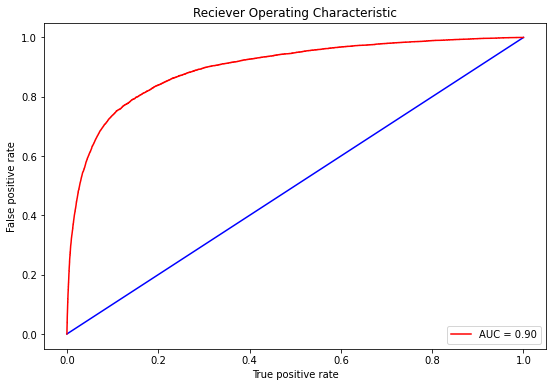

In [ ]:
#ROC AUC curve

col = 'disrespect'
print("Column:",col)
pred_pro_1 = model.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro_1)
auc_val =auc(frp,trp)
plt.figure(figsize=(9,6))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

In [ ]:
col = 'disrespect'
print("Column:",col)
pred =  model.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: disrespect

Confusion matrix
 [[121289     89]
 [  5961    317]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    121378
           1       0.78      0.05      0.09      6278

    accuracy                           0.95    127656
   macro avg       0.87      0.52      0.54    127656
weighted avg       0.94      0.95      0.93    127656



## SGD with squared hinge loss

Building 0 model for column:harsh
Building 1 model for column:extremely_harsh
Building 2 model for column:vulgar
Building 3 model for column:threatening
Building 4 model for column:disrespect
Building 5 model for column:targeted_hate
Column: disrespect


Text(0.5, 1.0, 'Reciever Operating Characteristic')

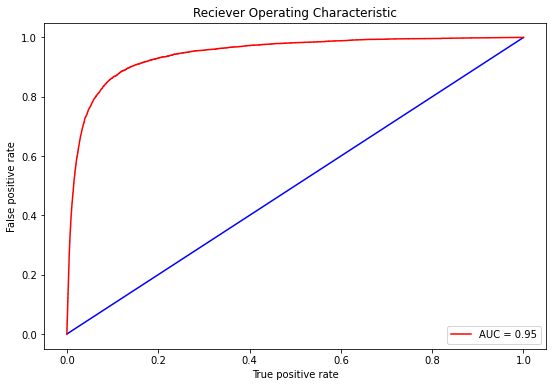

In [ ]:
sgdc = SGDClassifier(loss="squared_hinge", eta0=0.001,penalty='l2',alpha=1e-3,max_iter=1000, random_state=42)   #initially did wih 0.001
model_1 = CalibratedClassifierCV(sgdc)    #calibrated SVM classifier

#prediction
prd_sgdc = np.zeros((x_test.shape[0],y.shape[1]))

for i,col in enumerate(target_col):

    print('Building {} model for column:{''}'.format(i,col))
    model_1.fit(X,y[col])

    prd_sgdc[:,i] = model_1.predict_proba(x_test)[:,1]




#ROC AUC curve

col = 'disrespect'
print("Column:",col)
pred_pro_1 = model_1.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro_1)
auc_val =auc(frp,trp)
plt.figure(figsize=(9,6))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')


## Results
The Logistic Regression model with TF-IDF vectorization performed best with an accuracy of 0.98276 on the private Kaggle leaderboard for the competition. Other models, such as SGD Classifier with Squared Hinge Loss, also showed strong performance. Below is a summary of the performance of each model:


| Model                          | Accuracy | ROC-AUC | F1-Score |
|--------------------------------|----------|---------|----------|
| Logistic Regression (TF-IDF)   | 0.98276  | 0.92    | 0.88     |
| SGD Classifier (Hinge Loss)    | 0.98218  | 0.90    | 0.87     |
| SGD Classifier (Squared Hinge) | 0.98366  | 0.95    | 0.89     |
| Multinomial Naive Bayes        | 0.94058  | 0.89    | 0.82     |


## Conclusion
In conclusion, the Logistic Regression model with TF-IDF vectorization and the SGD Classifier with Squared Hinge Loss are the most effective for harsh comment detection. Their high accuracy and robust performance across multiple categories make them suitable for real-world applications.